In [74]:
import pandas as pd
df = pd.read_pickle('accels0.pkl')

In [22]:
len(df)/25

48.72

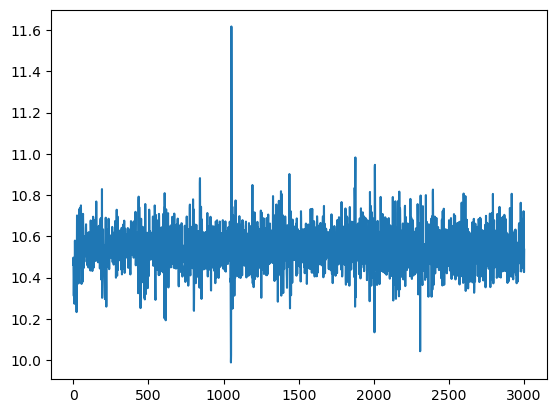

In [36]:
import matplotlib.pyplot as plt
plt.plot(df['accel_absolute'])

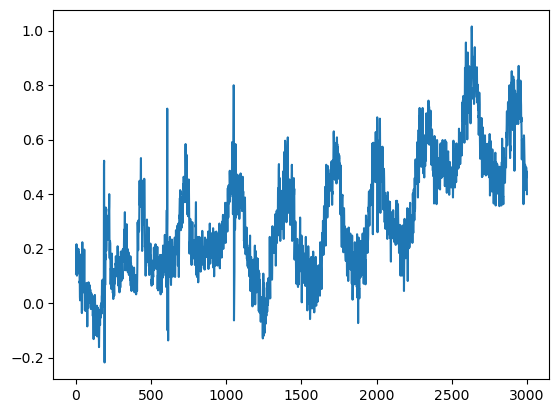

In [37]:
plt.plot(df['accel_x'])

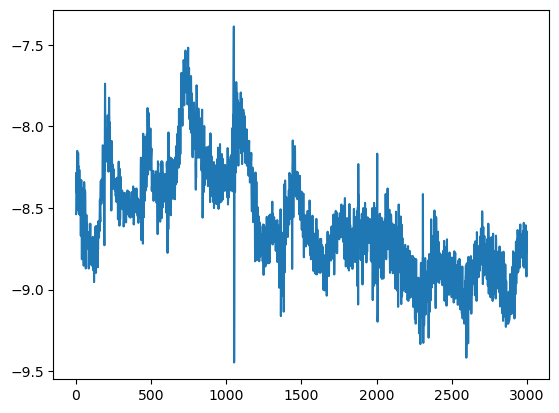

In [38]:
plt.plot(df['accel_y'])

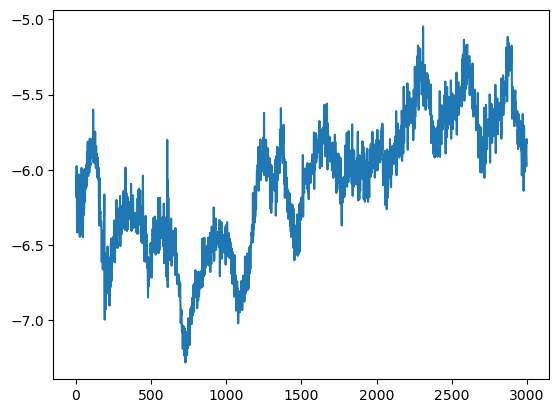

In [39]:
plt.plot(df['accel_z'])

In [12]:
from scipy.signal import butter, filtfilt, periodogram
import numpy as np
accels = df
# 1. High-pass filtering
def high_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)
sample_rate = 48.72
# Apply high-pass filter to remove static acceleration (gravity)
cutoff_frequency = 1  # Hz
accels['accel_x'] = high_pass_filter(accels['accel_x'], cutoff_frequency, sample_rate)
accels['accel_y'] = high_pass_filter(accels['accel_y'], cutoff_frequency, sample_rate)
accels['accel_z'] = high_pass_filter(accels['accel_z'], cutoff_frequency, sample_rate)

# 2. Compute Energy Expenditure (EE)
# EE = sqrt(accel_x^2 + accel_y^2 + accel_z^2)
accels['EE'] = np.sqrt(accels['accel_x']**2 + accels['accel_y']**2 + accels['accel_z']**2)

# Determine EE category
def classify_activity(ee):
    if ee < 100:
        return 'Low'
    elif 100 <= ee < 400:
        return 'Medium'
    else:
        return 'High'

# Average EE over the dataset for activity classification
average_ee = accels['EE'].mean()
activity_level = classify_activity(average_ee)

# 3. Band-pass filtering for respiration
def band_pass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, data)

# Define filter parameters based on activity level
if activity_level == 'Low':
    lowcut, highcut = 0.2, 0.4
elif activity_level == 'Medium':
    lowcut, highcut = 0.3, 0.5
else:  # High
    lowcut, highcut = 0.4, 0.6

accels['resp_x'] = band_pass_filter(accels['accel_x'], lowcut, highcut, sample_rate)
accels['resp_y'] = band_pass_filter(accels['accel_y'], lowcut, highcut, sample_rate)
accels['resp_z'] = band_pass_filter(accels['accel_z'], lowcut, highcut, sample_rate)

# 4. Breathing frequency estimation using the power spectral density
def estimate_breathing_frequency(signal, fs):
    f, Pxx = periodogram(signal, fs)
    peak_freq = f[np.argmax(Pxx)]  # Find the frequency with the highest power
    return peak_freq

breathing_freq_x = estimate_breathing_frequency(accels['resp_x'], sample_rate)
breathing_freq_y = estimate_breathing_frequency(accels['resp_y'], sample_rate)
breathing_freq_z = estimate_breathing_frequency(accels['resp_z'], sample_rate)

breathing_freq_x, breathing_freq_y, breathing_freq_z

(0.21041860465116283, 0.21041860465116283, 0.21041860465116283)

In [29]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, periodogram

def moving_average_filter(data, window_size):
    return data.rolling(window=window_size, center=True).mean()

def resample_data(data, original_rate, target_rate):
    ratio = target_rate / original_rate
    return data.iloc[::int(1/ratio)]

def butter_lowpass_filter(data, cutoff, fs, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def estimate_breathing_frequency(data, fs):
    f, Pxx = periodogram(data, fs)
    peak_freq = f[np.argmax(Pxx)]  # Frequency with the highest power
    return peak_freq

# Parameters
original_sample_rate = 49  # Original data sampling rate (Hz)
target_sample_rate = 10    # Target sampling rate after resampling (Hz)
moving_avg_window = 5      # Window size for moving average filter
lowpass_cutoff = 0.6       # Cutoff frequency for low-pass filter (Hz)

# Preprocessing
accels['smoothed'] = moving_average_filter(accels['accel_absolute'], moving_avg_window)
# Resample and reset index
resampled_data = accels['smoothed'].dropna().iloc[::original_sample_rate // target_sample_rate].reset_index(drop=True)

# Low-pass filtering
filtered_data = butter_lowpass_filter(resampled_data, lowpass_cutoff, target_sample_rate)

# Add filtered data to a new DataFrame for consistency
filtered_df = pd.DataFrame({'filtered': filtered_data})

# Estimate Breathing Frequency
breathing_frequency = estimate_breathing_frequency(filtered_df['filtered'], target_sample_rate)

print(f"Estimated Breathing Frequency: {breathing_frequency:.2f} Hz ({breathing_frequency * 60:.1f} breaths/min)")


Estimated Breathing Frequency: 0.20 Hz (12.0 breaths/min)


In [28]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch

def get_breathing_frequency(accels, sample_rate, low_cut=0.1, high_cut=0.5):
    """
    Extract the dominant breathing frequency from accelerometer data.

    Parameters:
    - accels (DataFrame): Accelerometer data with columns ['accel_x', 'accel_y', 'accel_z', 'accel_absolute'].
    - sample_rate (float): Sampling rate of the accelerometer data in Hz.
    - low_cut (float): Lower cutoff frequency for breathing (e.g., 0.1 Hz).
    - high_cut (float): Upper cutoff frequency for breathing (e.g., 0.5 Hz).

    Returns:
    - breathing_frequency (float): Dominant breathing frequency in Hz.
    """
    def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
        """Apply a bandpass Butterworth filter to the data."""
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)
    
    # Apply bandpass filter to the 'accel_absolute' column (or another signal if preferred)
    filtered_signal = butter_bandpass_filter(accels['accel_absolute'], low_cut, high_cut, sample_rate)

    # Compute Power Spectral Density (PSD) to find dominant frequency
    freqs, psd = welch(filtered_signal, fs=sample_rate, nperseg=1024)

    # Identify the frequency with the highest power in the breathing range
    breathing_idx = np.argmax(psd)
    breathing_frequency = freqs[breathing_idx]

    return breathing_frequency

# Extract the breathing frequency
breathing_frequency = get_breathing_frequency(accels, sample_rate)
print(f"Breathing Frequency: {breathing_frequency:.2f} Hz")

Breathing Frequency: 0.24 Hz


1000

In [34]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch

def estimate_respiratory_waveform(accels, sample_rate):
    """
    Estimate the respiratory waveform and dominant breathing frequency from accelerometer data.
    
    Parameters:
    - accels (DataFrame): Accelerometer data with columns ['accel_x', 'accel_y', 'accel_z', 'accel_absolute'].
    - sample_rate (float): Sampling rate of the accelerometer data in Hz.

    Returns:
    - breathing_frequency (float): Dominant breathing frequency in Hz.
    - respiratory_waveform (ndarray): Filtered signal representing the respiratory waveform.
    """
    accels = accels[:1024]
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y

    # Define the frequency range for respiratory signals (e.g., 0.1 to 0.5 Hz)
    lowcut = 0.1
    highcut = 0.5

    # Apply bandpass filter to the 'accel_absolute' column
    respiratory_waveform = bandpass_filter(accels['accel_absolute'], lowcut, highcut, sample_rate)

    # Compute Power Spectral Density (PSD) to find dominant frequency
    freqs, psd = welch(respiratory_waveform, fs=sample_rate, nperseg=1024)

    # Identify the frequency with the highest power in the breathing range
    breathing_idx = np.argmax(psd)
    breathing_frequency = freqs[breathing_idx]

    return breathing_frequency, respiratory_waveform
# Estimate the respiratory waveform and breathing frequency
breathing_frequency, respiratory_waveform = estimate_respiratory_waveform(accels, sample_rate)
print(f"Dominant Breathing Frequency: {breathing_frequency:.2f} Hz")

Dominant Breathing Frequency: 0.38 Hz


In [51]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt, welch

def estimate_breathing_with_pca(accels, sample_rate):
    """
    Estimate the breathing frequency using PCA on accelerometer data.

    Parameters:
    - accels (DataFrame): Accelerometer data with columns ['accel_x', 'accel_y', 'accel_z'].
    - sample_rate (float): Sampling rate of the accelerometer data in Hz.

    Returns:
    - breathing_frequency (float): Dominant breathing frequency in Hz.
    - respiratory_waveform (ndarray): Filtered signal representing the respiratory waveform.
    """
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y

    # Combine accelerometer data using PCA
    pca = PCA(n_components=1)
    dominant_motion = pca.fit_transform(accels[['accel_x', 'accel_y', 'accel_z']])
    dominant_motion = dominant_motion.flatten()  # Flatten to 1D array

    # Define the frequency range for respiratory signals (e.g., 0.1 to 0.5 Hz)
    lowcut = 0.1
    highcut = 0.5

    # Apply bandpass filter to the PCA output
    respiratory_waveform = bandpass_filter(dominant_motion, lowcut, highcut, sample_rate)

    # Compute Power Spectral Density (PSD) to find dominant frequency
    freqs, psd = welch(respiratory_waveform, fs=sample_rate, nperseg=1024)

    # Identify the frequency with the highest power in the breathing range
    breathing_idx = np.argmax(psd)
    breathing_frequency = freqs[breathing_idx]

    return breathing_frequency, respiratory_waveform

sample_rate = 48.72  # Hz

# Estimate the breathing frequency using PCA
breathing_frequency, respiratory_waveform = estimate_breathing_with_pca(accels, sample_rate)
print(f"Dominant Breathing Frequency: {breathing_frequency:.2f} Hz")


Dominant Breathing Frequency: 0.10 Hz


Total Breaths Detected: 19


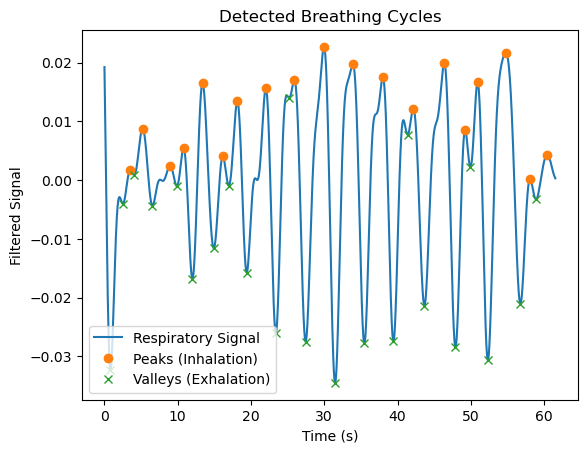

In [52]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

def count_breaths(accels, sample_rate, lowcut=0.1, highcut=0.5, min_peak_distance=1.5):
    """
    Count breaths from accelerometer data by detecting breathing cycles.

    Parameters:
    - accels (DataFrame): Accelerometer data with columns ['accel_x', 'accel_y', 'accel_z', 'accel_absolute'].
    - sample_rate (float): Sampling rate of the accelerometer data in Hz.
    - lowcut (float): Lower cutoff frequency for breathing (e.g., 0.1 Hz).
    - highcut (float): Upper cutoff frequency for breathing (e.g., 0.5 Hz).
    - min_peak_distance (float): Minimum time (in seconds) between consecutive peaks.

    Returns:
    - breath_count (int): Total number of detected breaths.
    - peaks (ndarray): Indices of detected peaks.
    - valleys (ndarray): Indices of detected valleys.
    """
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y

    # Bandpass filter to isolate breathing signal
    respiratory_signal = bandpass_filter(accels['accel_absolute'], lowcut, highcut, sample_rate)

    # Detect peaks (inhalation peaks)
    min_samples_between_peaks = int(min_peak_distance * sample_rate)
    peaks, _ = find_peaks(respiratory_signal, distance=min_samples_between_peaks)

    # Detect valleys (exhalation points)
    valleys, _ = find_peaks(-respiratory_signal, distance=min_samples_between_peaks)

    # Count breathing cycles (each peak-valley pair is one breath)
    breath_count = min(len(peaks), len(valleys))

    return breath_count, peaks, valleys, respiratory_signal


sample_rate = 48.72  # Hz

# Count breaths and get additional info
breath_count, peaks, valleys, respiratory_signal = count_breaths(accels, sample_rate)
print(f"Total Breaths Detected: {breath_count}")

# Plotting (optional, for visualization)
import matplotlib.pyplot as plt
time = np.arange(len(respiratory_signal)) / sample_rate
plt.plot(time, respiratory_signal, label="Respiratory Signal")
plt.plot(time[peaks], respiratory_signal[peaks], "o", label="Peaks (Inhalation)")
plt.plot(time[valleys], respiratory_signal[valleys], "x", label="Valleys (Exhalation)")
plt.xlabel("Time (s)")
plt.ylabel("Filtered Signal")
plt.legend()
plt.title("Detected Breathing Cycles")
plt.show()


In [57]:
#hal science

import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import pandas as pd

def calculate_respiratory_rate(accels, sampling_rate=48.72, target_rate=5):
    """
    Calculate respiratory rate from accelerometer data.
    
    Parameters:
    accels: DataFrame with 'accel_x', 'accel_y', 'accel_z' columns representing raw accelerometer signals.
    sampling_rate: Sampling rate of the input signal in Hz (default 256Hz).
    target_rate: Target sampling rate after resampling (default 5Hz).
    
    Returns:
    Respiratory rate in Hz.
    """
    # Step 1: Combine signals into a single signal by summing absolute values
    combined_signal = np.sqrt(accels['accel_x']**2 + accels['accel_y']**2 + accels['accel_z']**2)
    
    # Step 2: Apply a moving average filter 
    window_size = int(sampling_rate * 0.5)  # 0.5 seconds
    moving_avg_signal = combined_signal.rolling(window=window_size, center=True).mean().dropna()
    
    # Step 3: Resample the signal to 5Hz
    resampling_factor = int(sampling_rate / target_rate)
    resampled_signal = moving_avg_signal[::resampling_factor]
    
    # Step 4: Perform spectral analysis to estimate the initial breathing frequency
    freq_spectrum = np.fft.rfft(resampled_signal - np.mean(resampled_signal))
    freqs = np.fft.rfftfreq(len(resampled_signal), 1 / target_rate)
    spectral_peak_freq = freqs[np.argmax(np.abs(freq_spectrum[(freqs >= 0.1) & (freqs <= 1)]))]
    
    # Step 5: Apply a 3rd-order Butterworth low-pass filter with a cutoff around the estimated frequency
    cutoff_freq = spectral_peak_freq + 0.01  # Adding a margin to the estimated frequency
    cutoff_freq = 1
    b, a = butter(3, cutoff_freq / (target_rate / 2), btype='low')  # Normalize cutoff freq
    filtered_signal = filtfilt(b, a, resampled_signal)
    
    # Step 6: Detect peaks in the filtered signal to determine respiratory rate
    peaks, _ = find_peaks(filtered_signal, distance=target_rate / spectral_peak_freq)
    breathing_rate = len(peaks) / (len(filtered_signal) / target_rate)  # Breaths per second (Hz)
    
    return breathing_rate



# Calculate the respiratory rate
respiratory_rate = calculate_respiratory_rate(df)
respiratory_rate


0.045317220543806644

In [33]:
from scipy.signal import resample

def refined_calculate_respiratory_rate(accels, sampling_rate=48.72, target_rate=5):
    """
    Refined calculation of respiratory rate from accelerometer data.
    
    Parameters:
    accels: DataFrame with 'accel_x', 'accel_y', 'accel_z' columns representing raw accelerometer signals.
    sampling_rate: Sampling rate of the input signal in Hz.
    target_rate: Target sampling rate after resampling in Hz.
    
    Returns:
    Respiratory rate in Hz.
    """
    # Step 1: Combine signals into a single magnitude signal
    combined_signal = np.sqrt(accels['accel_x']**2 + accels['accel_y']**2 + accels['accel_z']**2)
    
    # Step 2: Apply a moving average filter with a window size proportional to the sampling rate
    window_size = int(sampling_rate * 0.5)  # 0.5 seconds
    if window_size % 2 == 0:  # Ensure window size is odd for centered filtering
        window_size += 1
    moving_avg_signal = combined_signal.rolling(window=window_size, center=True).mean().dropna()
    
    # Step 3: Resample the signal to the target rate (e.g., 5Hz)
    resampled_length = int(len(moving_avg_signal) * (target_rate / sampling_rate))
    resampled_signal = resample(moving_avg_signal, resampled_length)
    
    # Step 4: Perform spectral analysis to estimate the respiratory frequency range (0.1Hz to 1Hz typical)
    freq_spectrum = np.fft.rfft(resampled_signal - np.mean(resampled_signal))
    freqs = np.fft.rfftfreq(len(resampled_signal), 1 / target_rate)
    valid_freqs = (freqs >= 0.1) & (freqs <= 1)
    if not valid_freqs.any():
        raise ValueError("No valid frequencies found in the expected range (0.1-1Hz).")
    spectral_peak_freq = freqs[np.argmax(np.abs(freq_spectrum[valid_freqs]))]
    
    # Step 5: Design a 3rd-order Butterworth filter around the spectral peak frequency
    margin = 0.05  # Small margin for cutoff
    low_cutoff = max(0.1, spectral_peak_freq - margin)
    high_cutoff = spectral_peak_freq + margin
    b, a = butter(3, [low_cutoff / (target_rate / 2), high_cutoff / (target_rate / 2)], btype='band')
    filtered_signal = filtfilt(b, a, resampled_signal)
    
    # Step 6: Detect peaks in the filtered signal to count breaths
    min_peak_distance = int(target_rate / spectral_peak_freq)
    peaks, _ = find_peaks(filtered_signal, distance=min_peak_distance)
    breathing_rate = len(peaks) / (len(resampled_signal) / target_rate)  # Breaths per second (Hz)
    
    return breathing_rate

# Test the function with the same dummy dataset for now
respiratory_rate_refined = refined_calculate_respiratory_rate(accels)
respiratory_rate_refined

ValueError: Wn[0] must be less than Wn[1]

In [75]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

SAMPLE_RATE = 48.72  # Hz

def refined_calculate_respiratory_rate(accels):
    """
    Refined calculation of respiratory rate from accelerometer data.
    
    Parameters:
    accels: DataFrame with 'accel_x', 'accel_y', 'accel_z' columns representing raw accelerometer signals
    Returns:
    Respiratory rate in Hz.
    """
    # Combine accelerometer signals to calculate the magnitude
    accels['magnitude'] = np.sqrt(accels['accel_x']**2 + accels['accel_y']**2 + accels['accel_z']**2)
    
    # Apply a moving average filter
    window_size = int(SAMPLE_RATE * 0.2)  # Approx 0.2 second window
    accels['filtered_magnitude'] = accels['magnitude'].rolling(window=window_size, center=True).mean()
    
    # Normalize the filtered signal
    filtered_signal = accels['filtered_magnitude'].dropna()
    normalized_signal = (filtered_signal - filtered_signal.min()) / (filtered_signal.max() - filtered_signal.min())
    
    # Interpolate using cubic spline
    time = np.linspace(0, len(normalized_signal) / SAMPLE_RATE, len(normalized_signal))
    cs = CubicSpline(time, normalized_signal)
    interpolated_signal = cs(time)
    
    # Find peaks in the interpolated signal
    peaks, _ = find_peaks(interpolated_signal, distance=SAMPLE_RATE / 2)  # Minimum distance of 0.5 seconds
    
    # Calculate respiratory rate
    num_peaks = len(peaks)
    duration_seconds = len(interpolated_signal) / SAMPLE_RATE
    respiratory_rate_hz = num_peaks / duration_seconds  # Hz
    return respiratory_rate_hz

# Example usage:
# Assuming 'accels' is a DataFrame with 'accel_x', 'accel_y', 'accel_z' columns
respiratory_rate_refined = refined_calculate_respiratory_rate(df)
respiratory_rate_refined


1.400842527582748